In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util.systems import Linear2D
from dsn.util.plot_util import plot_opt, assess_constraints, dsn_pairplots
from dsn.util.dsn_util import get_savedir
from tf_util.stat_util import approx_equal
warnings.filterwarnings("ignore")

EPS = 1e-16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# filename info
basedir = '/Users/sbittner/Documents/dsn/dsn/';

num_rs = 1
start_rs = 3

omega = 1
bstr = 'd'


c_init = 0
sigma_init = 1.0;

Linear2D
{'type': 'oscillation', 'means': array([0.        , 6.28318531]), 'variances': array([1., 1.])}
0
entropy
i
0


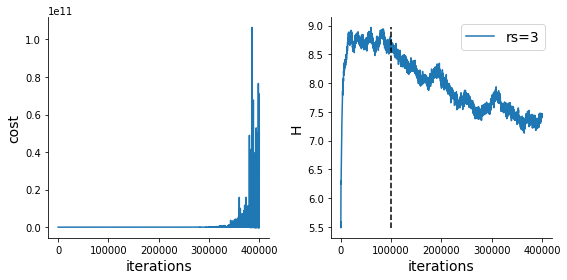

constraints
con 0
con 1
con 2
con 3


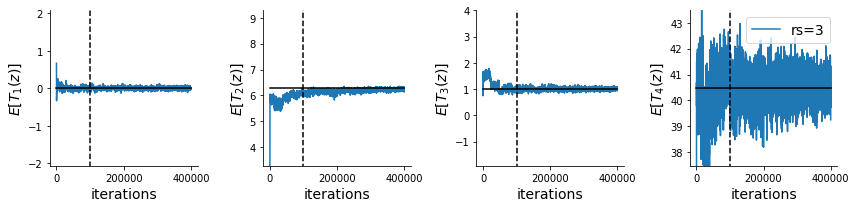

p values
0


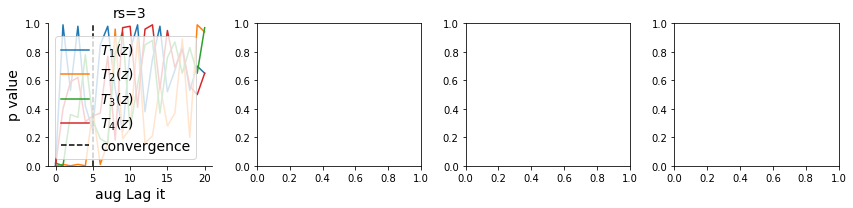

In [6]:

tau = 1.0
mu = np.array([0.0, 2*np.pi*omega]);
Sigma = np.array([1.0, 1.0]);
behavior = {'type':'oscillation', 'means':mu, 'variances':Sigma};

latent_dynamics = None;
TIF_flow_type = 'PlanarFlow';
mult_and_shift = 'post';
nlayers = 10;
arch_dict = {'D':4, \
             'latent_dynamics':latent_dynamics, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};

fixed_params = {'tau':tau}

system = Linear2D(fixed_params, behavior);
print(system.name)

lr_order = -3
dir_str = 'Linear2D/%dHz/%s/' % (omega, bstr)

fnames = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, \
                                    c_init, rs, dir_str)
    fname = savedir + 'opt_info.npz';
    fnames.append(fname);
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
    if (rs==start_rs):
        npzfile = np.load(fnames[0]);
        mu = npzfile['mu'];
        check_rate = npzfile['check_rate'];
        last_ind = npzfile['it']//check_rate;
        nits = npzfile['costs'].shape[0];
        k_max = npzfile['T_xs'].shape[0]-1;
        iterations = np.arange(0, check_rate*nits, check_rate);
        npz_behavior = npzfile['behavior'][()]
        # check that behavior is right
        #TODO fixed params assert(npz_behavior['tau'] == behavior['tau'])
        print(npz_behavior)
        assert(approx_equal(npz_behavior['means'], behavior['means'], EPS))
        assert(approx_equal(npz_behavior['variances'], behavior['variances'], EPS))
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, plotR2=False);

-8.675565145155705 1.4235008319163467


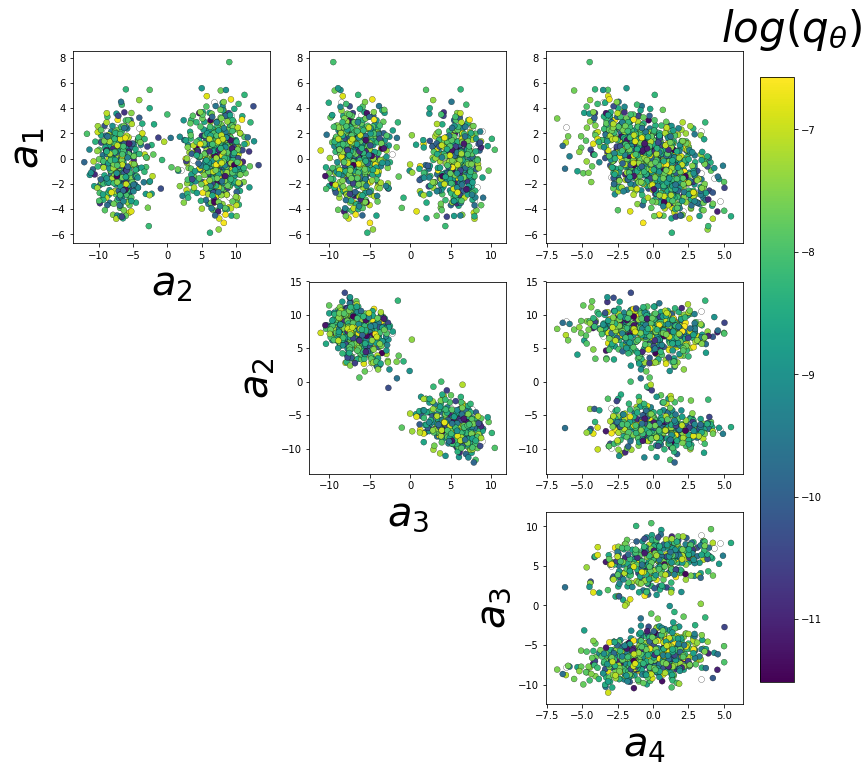

In [8]:
pfname = 'images/linear2D_DSN_Z.png'
#lims = [-15, 15]
lims = None
dsn_pairplots(fnames, 'Zs', system, system.D, 'identity', 'log_q_z', \
             [], AL_final_its, xlims=lims, ylims=lims, tri=True, \
             fontsize=40, pfname=pfname);

-8.675565145155705 1.4235008319163467


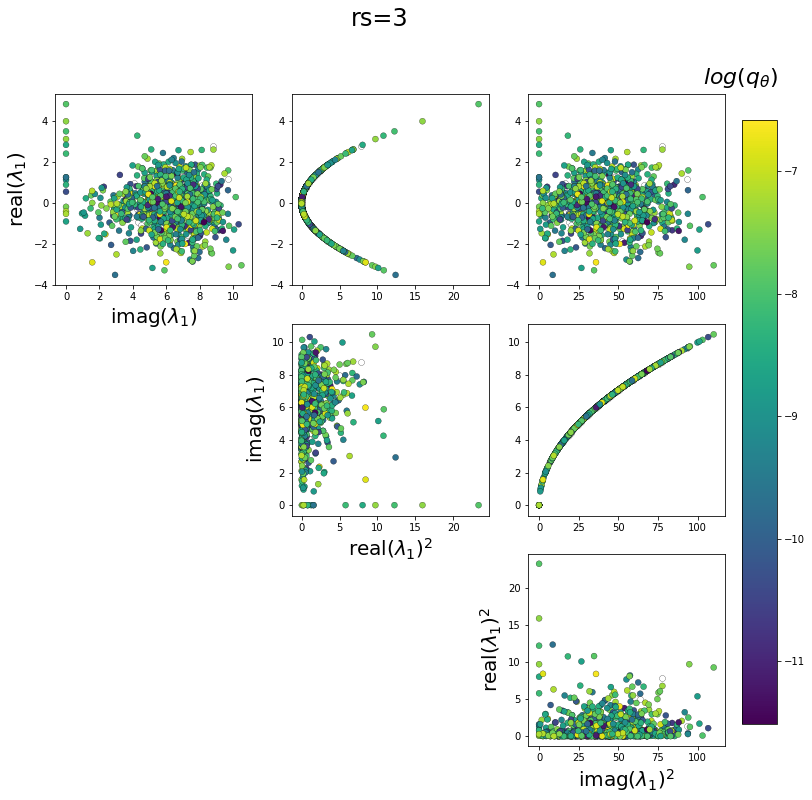

In [9]:
pfname = 'images/linear2D_DSN_T_x.png'
dsn_pairplots(fnames, 'T_xs', system, system.D, 'identity', 'log_q_z', \
             legendstrs, AL_final_its, fontsize=20, pfname=pfname);

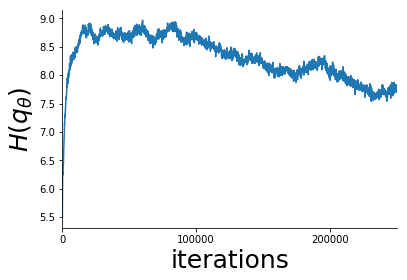

In [6]:
special_plot = True
if (special_plot):
    it_converge = AL_final_its[0]*50000;
    fontsize = 25;
    Hs = npzfile['Hs'];
    fig = plt.figure();
    ax = fig.add_subplot(111);
    plt.plot(iterations[:last_ind], Hs[:last_ind]);
    #plt.plot([it_converge, it_converge], [np.min(Hs), np.max(Hs)], 'k--');
    plt.xlabel('iterations', fontsize=fontsize);
    plt.ylabel(r'$H(q_\theta)$', fontsize=fontsize);
    plt.xlim([0, it_converge])
    ax.set_xticks([0, 100000, 200000])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig('images/linear_2D_opt_H.png')
    plt.show();

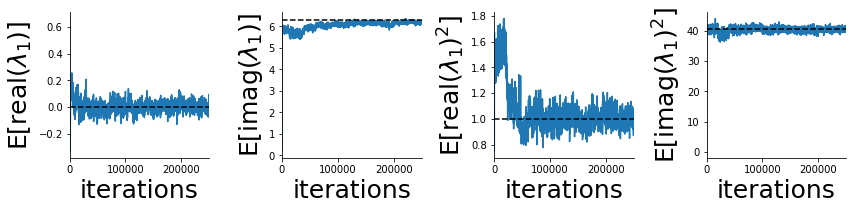

In [7]:
fontsize = 25
if (special_plot):
    it_converge = AL_final_its[0]*50000;
    mean_T_phis = npzfile['mean_T_xs'];
    n_suff_stats = mean_T_phis.shape[1];
    n_cols = 4;
    n_rows = int(np.ceil(n_suff_stats/n_cols));
    figsize = (n_cols*3, n_rows*3);
    fig2 = plt.figure(figsize=figsize);
    for i in range(n_suff_stats):
        ax = plt.subplot(n_rows,n_cols,i+1);
        plt.plot(iterations[:last_ind], mean_T_phis[:last_ind,i]);
        #plt.plot([it_converge, it_converge], [np.min(mean_T_phis[:,i]), np.max(mean_T_phis[:,i])], 'k--');
        plt.plot([iterations[0], iterations[last_ind]], [mu[i], mu[i]], 'k--');
        plt.ylabel(r'E[%s]' % system.T_x_labels[i], fontsize=fontsize);
        if (i > n_suff_stats - n_cols - 1):
            plt.xlabel('iterations', fontsize=fontsize);
        ax.set_xticks([0, 100000, 200000])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlim([0, it_converge])
    plt.tight_layout()
    plt.savefig('images/linear_2D_opt_con.png')
    plt.show();